In [3]:
#@title
%%capture
!pip install git+https://github.com/grading/gradememaybe.git
!gdown '1vg1ke0FR8xkGXUl2rrQsADPEjcMSqlwK'
!unzip avalia.zip
from gofer import ok

# Parte 1: Leitura e Preparação dos Dados

## Importação de Bibliotecas

Na célula de código abaixo importamos todas as principais bibliotecas (módulos do Python) que usaremos em nosso exercício.

In [4]:
import numpy as np

import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt

## Leitura dos Dados

O código abaixo faz a leitura das imagens de entrada e suas correspondentes categorias de saída desejada.

In [5]:
# Baixa as entradas X.npy
!gdown https://drive.google.com/uc?id=1oSRay8phFA91RJoGH0tMmj86LBovKj73

# Baixa as saídas desejadas Y.npy
!gdown https://drive.google.com/uc?id=1_BQLcsgcYYsubtv4M80BVm4BEknrTOr7

Downloading...
From: https://drive.google.com/uc?id=1oSRay8phFA91RJoGH0tMmj86LBovKj73
To: /content/X.npy
100% 33.8M/33.8M [00:00<00:00, 39.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_BQLcsgcYYsubtv4M80BVm4BEknrTOr7
To: /content/Y.npy
100% 165k/165k [00:00<00:00, 98.0MB/s]


In [6]:
# Leitura dos dados
X = np.load('X.npy')
Y = np.load('Y.npy')

# Reordena as categorias na ordem correta
# (por motivo que desconheço, os dados
#  originais estavam com as classes fora
#  de ordem -- consistentes e organizadas,
#  mas fora de ordem)
cats = [9,0,7,6,1,8,4,3,2,5]
Y[:,cats] = Y[:,range(10)]

## Embaralhamento e Separação dos Dados

Em seguida embaralhamos as amostras, mantendo os pares correspondentes entre entradas e suas respectivas saídas desejadas, e depois separamos uma parte das amostras para treinamento e outra parte para validação.

In [7]:
def split_and_shuffle(X, Y, perc = 0.1):
  ''' Esta função embaralha os pares de entradas
      e saídas desejadas, e separa os dados de
      treinamento e validação
  '''
  # Total de amostras
  tot = len(X)
  # Emabaralhamento dos índices
  indexes = np.arange(tot)
  np.random.shuffle(indexes)
  # Calculo da quantidade de amostras de
  # treinamento
  n = int((1 - perc)*tot)
  Xt = X[indexes[:n]]
  Yt = Y[indexes[:n]]
  Xv = X[indexes[n:]]
  Yv = Y[indexes[n:]]
  return Xt, Yt, Xv, Yv

In [8]:
# Aqui efetivamente realizamos a separação
# e embaralhamento

Xt, Yt, Xv, Yv = split_and_shuffle(X, Y)

In [11]:
# Transforma os arrays do NumPy em
# tensores do PyTorch

Xt = torch.from_numpy(Xt)
Yt = torch.from_numpy(Yt)
Xv = torch.from_numpy(Xv)
Yv = torch.from_numpy(Yv)

In [12]:
# Adiciona dimensão dos canais
# (único canal, imagem monocromática)

Xt = Xt.unsqueeze(1)
Xv = Xv.unsqueeze(1)

In [13]:
print('Dados de treinamento:')
print('Xt', Xt.size(), 'Yt', Yt.size())
print()
print('Dados de validação:')
print('Xv', Xv.size(), 'Yv', Yv.size())

Dados de treinamento:
Xt torch.Size([1855, 1, 64, 64]) Yt torch.Size([1855, 10])

Dados de validação:
Xv torch.Size([207, 1, 64, 64]) Yv torch.Size([207, 10])


## Inspeção dos Dados

Agora mostramos algumas amostras dos dados para verificar se a preparação feita até aqui continua coerente.

In [14]:
def show_sample(X, Y, n=3):
  ''' Essa função mostra algumas
      amostras aleatórias
  '''
  for i in range(n):
    k = np.random.randint(0,len(X))
    print('Mostrando', int(torch.argmax(Y[k,:])))
    plt.imshow(X[k,0,:,:], cmap='gray')
    plt.show()

In [ ]:
show_sample(Xt, Yt)

# Parte 2: Projeto da Rede Neural

Para esta primeira parte do exercício você irá implementar uma rede neural convolucional conforme a figura abaixo. Primeiro examine com calma a figura, tentando entender cada etapa da rede neural. Ela é muito semelhante à rede neural que implementamos em aula, disponível [aqui](https://colab.research.google.com/drive/1bT8jyS0qyScFLi_mA6c1Fbv9uixrNRO3?usp=sharing).

<center>
<img src="https://drive.google.com/uc?id=14lWGdvUGpK_CiVH9M6E-LxGx57pV29xk" width="1000"/>
</center>

Considere a fórmula abaixo, onde $w_i$ representa a largura da imagem de entrada, $p$ o tamanho do padding (se não houver padding, $p$=0), $k$ a largura do kernel, $s$ o tamanho do passo (stride). Essa fórmula calcula a largura $w_o$ do feature map de saída após a convolução. A mesma fórmula pode ser usada para calcular a altura também.

$w_o = \frac{w_i + 2p - k}{s}+1$

Na rede neural da figura acima, as camadas são:

1.   `conv1`: Camada convolucional com kernel 6x6, 5 canais de saída, sem padding, stride 2 e ativação ReLU.
2.   `pool1`: Camada _max-pooling_ 2x2, com stride 2.
3.   `conv2`: Camada convolucional com kernel 3x3, 8 canais de saída, sem padding, stride 1 e ativação ReLU.
4.   `drp1`: Dropout de 25%
5.   `pool2`: Camada _max-pooling_ 2x2, com stride 2.
6.   `lin1`: Camada feedforward que recebe os dados serializados e gera as saídas. A função de ativação final é _softmax_, mas ela é implementada no cálculo da função de custo, então não precisa ser considerada aqui.

Com base nas informações e na figura acima, e usando a fórmula cima, considerando que a entrada é de 1 canal, largura 64 e altura 64 (1x64x64), defina os valores de `N1`, `N2`, `N3`, `N4`, `N5`, `N6`, `N7`, `N8`, `N9`, `N10`, `N11`, `N12` conforme apontados na figura.

Preencha os valores no código abaixo.

In [15]:
# Para cada uma das variáveis abaixo
# substitua None pelo valor inteiro
# correto.

N1 = 5 #canais de saída
N2 = 30 #wo=wi+2p−k/s +1 --> w0 = ((64 + 2*0 - 6)/2)   + 1 --> 30
N3 = 4500# 5*30*30 = 4500
N4 = 5#canais de saída
N5 = 15#wo=wi+2p−k/s +1 --> w0 = ((30 + 2*0 - 2 ) / 2 ) + 1 = 15
N6 = 1125#5*15*15 = 1125
N7 = 8#canais saída
N8 = 13#wo=wi+2p−k/s +1 --> w0 = ((15 + 2*0 - 3 ) / 1 ) + 1 = 13
N9 = 1352#8*13*13 = 1352
N10 = 8#saídas
N11 = 6#wo=wi+2p−k/s +1 --> w0 = (13 + 2*0 - 2) / 2 ) + 1 = 6 => aprox
N12 = 288#8*6*6 = 288
N13 = 10     

## Autovaliação do código até aqui

In [16]:
ok.check('avalia01.py')

# Parte 3: Código da Rede Neural

Crie abaixo uma classe de nome `ConvNet`. Essa classe deve derivar da classe `nn.Module`. Se você estiver com dúvidas sobre como começar, revise o código desenvolvido em aula [aqui](https://colab.research.google.com/drive/1bT8jyS0qyScFLi_mA6c1Fbv9uixrNRO3?usp=sharing). Nesta classe, você vai definir uma rede convolucional com as seguintes camadas:



1.   A primeira camada você vai chamar de `self.conv1`. Essa deve receber a imagem de entrada e aplicar uma convolução com um kernel de tamanho 6x6, com passo 2 (stride=2). A saída deve conter 5 canais.
2.   A segunda camada deve ser uma camada de _max-pooling_ numa janela 2x2, com passo 2. Essa camada você vai chamar de `self.pool1`.
3.   A terceira camada você vai chamar de `self.conv2`. Ela deve ser uma convolução com um kernel de tamanho 3x3, gerando 8 canais de saída.
4.   Em seguida voce tomará a saída da terceira camada e aplicará _dropout_ com p=25%. Essa camada de _dropout_ você vai chamar de `self.drp1`.
5.   Após o _dropout_, adicione mais uma camada de _max-pooling_ idêntica à usada na segunda camada, com janela 2x2 e passo 2. Essa camada você vai chamar de `self.pool2`
6.   Agora os dados serão serializados. Adicione uma camada _feed-forward_ de nome `self.lin1` que receberá os dados serializados e gerará as saídas.



In [17]:
# Escreva aqui o código da classe que
# implementará sua rede neural
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 5,6,2)
    self.pool1 = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(5, 8, kernel_size=3)
    self.drp1 = nn.Dropout2d(0.25)               
    self.pool2 = nn.MaxPool2d(2, 2)
    self.lin1 = nn.Linear(288, 10)             
  def forward(self, x):
    x = self.conv1(x)
    x = torch.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.drp1(x)
    x = torch.relu(x)
    x = self.pool2(x)
    x = x.view(-1, 288)
    x = self.lin1(x)
    return x




A célula de código abaixo vai criar um objeto da classe recém criada por você, e irá imprimir um sumário das camadas. Verifique se constam as camadas `conv1`, `pool1`, `conv2`, `drp1`, `pool2` e `lin1`, com os respectivos parâmetros pedidos no enunciado. Lembre que `conv1` e que as camadas de _max-pooling_ `pool1` e `pool2` devem possuir stride 2.

In [18]:
cnn = ConvNet()
print(cnn)

ConvNet(
  (conv1): Conv2d(1, 5, kernel_size=(6, 6), stride=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 8, kernel_size=(3, 3), stride=(1, 1))
  (drp1): Dropout2d(p=0.25, inplace=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lin1): Linear(in_features=288, out_features=10, bias=True)
)


## Autovaliação do código até aqui

In [19]:
ok.check('avalia02.py')

# Parte 4: Treinamento

Agora você vai implementar o código para treinamento da rede neural. Para facilitar, já estão implementadas abaixo algumas partes desse código.

A função `evaluate(x, y_hat)` vai servir para verificar a acurácia da rede neural para um par de entradas `x` e saídas desejadas correspondentes `y_hat`. Cuide que o nome de sua variável correspondente ao objeto da rede neural deve ser `cnn` para usar essa função.

In [20]:
def evaluate(x, y_hat):
  ''' Calcula a acurácia da ConvNet (variável cnn)
      para o par de entradas e saídas desejadas
      x, y_hat. Aqui assume-se que y_hat está
      originalmente no formato one-hot. Tanto
      x quanto y_hat devem ser lotes, não amostras
      individuais.
  '''
  y = cnn(x).argmax(dim=1)
  y_hat = y_hat.argmax(dim=1)
  return 100*float((y == y_hat).sum()) / len(y)

Abaixo criamos os objetos `opt` que será o otimizador Adam, com passo de aprendizagem 0,0001, e função de custo entropia cruzada no objeto `loss`.

In [21]:
opt = optim.Adam(cnn.parameters(), lr=0.0001)
loss = nn.CrossEntropyLoss()

Em seguida movemos os dados e a rede neural para a GPU, para que o treinamento seja um pouco mais ágil. Essa parte é opcional, depende de você ter GPU disponível e com memória suficiente para alocar todos os dados. Testando no Google Colab consegui alocar tudo normalmente.

In [22]:
# Movemos tudo para a GPU
# (essa parte é opcional)

gpu = torch.device("cuda:0")
cnn = cnn.to(gpu)
Xt = Xt.to(gpu, dtype=torch.float)
Yt = Yt.to(gpu, dtype=torch.long)
Xv = Xv.to(gpu, dtype=torch.float)
Yv = Yv.to(gpu, dtype=torch.long)

Agora complete você mesmo o código abaixo, colocando os comandos que faltam nos espaços indicados conforme as instruções.

In [24]:
# Laço de treinamento para 2001
# épocas

for j in range(2001):

  # Faremos o treinamento em lotes de
  # tamanho igual a 128 amostras

  for i in range(0,len(Yt),128):

    # Separa o lote de entradas
    x = Xt[i:i+128,:,:,:]

    # Separa o lote de saídas desejadas
    # já transformando de one-hot para
    # índice das colunas.
    y_hat = Yt[i:i+128,:].argmax(dim=1)

    # Zera o gradiente do otimizador
    # (SEU CÓDIGO AQUI)
    opt.zero_grad()

    # Calcula a saída da rede neural
    # (SEU CÓDIGO AQUI)
    y = cnn(x)

    # Calcula o erro
    # (SEU CÓDIGO AQUI)
    e = loss(y, y_hat)

    # Calcula o gradiente usando
    # backpropagation
    # (SEU CÓDIGO AQUI)
    e.backward()

    # Realiza um passo de atualização
    # dos parâmetros da rede neural
    # usando o otimizador.
    # (SEU CÓDIGO AQUI)
    opt.step()

  # A cada 200 épocas imprimimos o
  # erro do último lote e a acurácia
  # nos dados de treinamento
  if not (j % 200):
    print(float(e), evaluate(Xt, Yt))

2.293119192123413 9.649595687331537
0.30129027366638184 85.12129380053908
0.14460089802742004 90.29649595687331
0.137408047914505 92.0754716981132
0.09222127497196198 93.26145552560646
0.05501977726817131 94.50134770889488
0.02844846621155739 95.68733153638814
0.13154171407222748 96.06469002695418
0.057252202183008194 95.90296495956873
0.032309118658304214 97.35849056603773
0.02097155712544918 97.30458221024259


Depois de treinar a rede neural, podemos desligar a camada de _dropout_ e mostrar o resultado nos dados de validação.

In [25]:
cnn.eval() # desliga dropout

ConvNet(
  (conv1): Conv2d(1, 5, kernel_size=(6, 6), stride=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 8, kernel_size=(3, 3), stride=(1, 1))
  (drp1): Dropout2d(p=0.25, inplace=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lin1): Linear(in_features=288, out_features=10, bias=True)
)

In [26]:
# Não modifique essa célula.

ac = evaluate(Xv, Yv)
print('Acurácia de', ac, '%')

Acurácia de 88.88888888888889 %


## Autovaliação do código até aqui

In [27]:
ok.check('avalia03.py')

# Parte 5: Examinando os Resultados

Por fim, podemos agora avaliar a rede neural em funcionamento, nos dados de validação.

A função abaixo escolhe 5 amostras aleatórias dos dados de validação e aplica sua rede neural nelas, mostrando a imagem, a saída calculada e a saída desejada.

In [28]:
def random_sample_cnn(X, Y):
  ''' Essa função testa a rede convolucional
      mostrando a imagem de entrada, a saída
      calculada, e a saída esperada, para
      5 amostras aleatórias.
  '''
  for _ in range(5):
    idx = np.random.randint(0, len(Yv))
    x = Xv[idx:idx+1,:,:,:]
    y = int(cnn(x).argmax(dim=1))
    y_hat = int(Yv[idx:idx+1,:].argmax(dim=1))
    print('y =', y, 'y_hat =', y_hat)
    x = x.cpu()
    plt.imshow(x[0,0,:,:], cmap='gray')
    plt.show()

Abaixo, finalmente, os resultados

y = 3 y_hat = 3


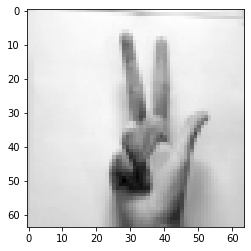

y = 4 y_hat = 3


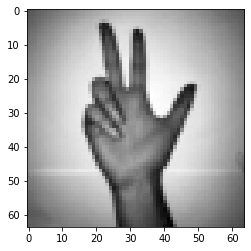

y = 4 y_hat = 4


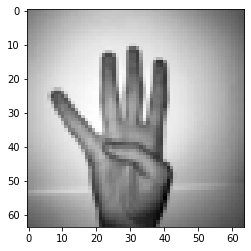

y = 9 y_hat = 9


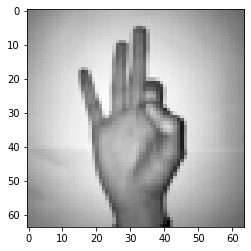

y = 4 y_hat = 4


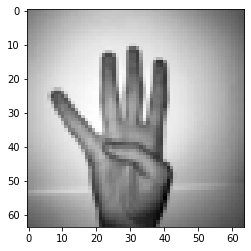

In [29]:
# Aqui examinamos alguns exemplos
# aleatórios nos dados de validação

random_sample_cnn(Xv, Yv)